In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np

from geopy import distance

In [2]:
pd.set_option('display.max_rows', 100)

# Main Data

In [3]:
main_df = pd.read_excel('./data/Tourism forecasting competition II dataset.xlsx', sheet_name='data for forecasting')
main_df['Date'] = pd.to_datetime(main_df['Unnamed: 0'], format='%YM%m').dt.normalize()
main_df = main_df.drop(columns='Unnamed: 0')
main_df = main_df.set_index('Date')

In [4]:
# missing values for Chile 2017 and Maldive 2013
main_df[main_df.isna().any(axis=1)]

,Canada,Chile,Mexico,Chinese Taipei,Hong Kong SAR,Japan,Korea (ROK),"Macao, China",Maldives,Cambodia,Indonesia,Singapore,New Zealand,USA,Thailand,Turkey,Australia,Hawaii,Austria,Czech
Date,,,,,,,,,,,,,,,,,,,,
1989-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1660.0,532.0,NaN,NaN
1989-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3090.0,1550.0,NaN,NaN
1989-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2570.0,822.0,NaN,NaN
1989-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1580.0,1010.0,NaN,NaN
1989-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1850.0,1383.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-01,23562.0,1059.0,9331.0,240629.0,3890000.0,96572.0,276234.0,1620434.0,NaN,45862.0,52237.0,121232.0,18496.0,130565.0,265428.0,11449.0,55560.0,8176.0,19859.0,17092.0
2017-11-01,29121.0,NaN,14247.0,244056.0,3680755.0,567149.0,299247.0,1981047.0,21195.0,127852.0,136770.0,251096.0,41808.0,173174.0,790839.0,28791.0,101350.0,7559.0,56124.0,44185.0
2017-12-01,43330.0,NaN,23756.0,248010.0,4232412.0,564264.0,332474.0,2068760.0,19918.0,133074.0,64325.0,244241.0,39296.0,203407.0,815704.0,25870.0,111540.0,9705.0,47706.0,36651.0


In [5]:
countries_list = main_df.columns.tolist()

# Currency

In [6]:
curr_df = pd.read_csv('./data/Currency.csv')
curr_df['Date'] = pd.to_datetime(curr_df['Date']).dt.normalize()
curr_df = curr_df.set_index('Date')

In [7]:
curr_df.head()

,Japan,Korea (ROK),Chile,Maldives,Cambodia,Singapore,USA,Chinese Taipei,Thailand,Indonesia,Turkey,"Macao, China",Australia,New Zealand,Czech,Hawaii,Mexico,Hong Kong SAR,Canada,Austria
Date,,,,,,,,,,,,,,,,,,,,
1989-01-01,34.042108,183.685626,73.320847,2.483129,NaN,0.520095,0.267982,7.465791,6.784561,486.159251,NaN,2.206563,0.308221,0.429202,NaN,0.267982,0.676061,2.212141,0.319117,0.239173
1989-02-01,34.215966,182.296189,74.181798,2.512286,NaN,0.516736,0.267937,7.426573,6.802541,491.867848,NaN,2.232473,0.314071,0.434895,NaN,0.267937,0.683999,2.211971,0.318345,0.241942
1989-03-01,34.920539,181.056747,74.823001,2.534002,NaN,0.520110,0.267996,7.395488,6.830051,496.119389,NaN,2.251770,0.328089,0.435435,NaN,0.267996,0.689912,2.213151,0.319997,0.243606
1989-04-01,35.394164,179.609012,75.045202,2.541527,NaN,0.522518,0.267996,7.238442,6.840328,497.592711,NaN,2.258457,0.333576,0.438143,NaN,0.267996,0.691960,2.208777,0.318466,0.244129
1989-05-01,36.901598,179.370299,77.957804,2.640167,NaN,0.524550,0.267731,6.921602,6.901245,516.904930,NaN,2.346110,0.347097,0.442048,NaN,0.267731,0.718816,2.199792,0.319163,0.253504


# Covid Data
up until march

In [8]:
covid_df = pd.read_csv('./data/CovidCases.csv')
covid_df['Date'] = pd.to_datetime(covid_df['Date']).dt.normalize()

In [9]:
covid_df.head()

,Country,Date,New Cases,New Deaths
0,Australia,2020-01-01,9.0,0.0
1,Australia,2020-02-01,16.0,0.0
2,Australia,2020-03-01,4334.0,21.0
3,Australia,2020-04-01,2387.0,74.0
4,Australia,2020-05-01,439.0,12.0


# FSI Data
up until 2023
Missing for ['Chinese Taipei', 'Hong Kong SAR', 'Macao, China', 'Hawaii']


In [10]:
fsi_df = pd.read_csv('./data/FSI.csv')
fsi_df['Year'] = pd.to_datetime(fsi_df['Year']).dt.normalize()

In [11]:
fsi_df.head()

,Country,Year,FSI Index
0,Cambodia,2008-01-01,85.8
1,Indonesia,2008-01-01,83.3
2,Maldives,2008-01-01,80.4
3,China,2008-01-01,80.3
4,Thailand,2008-01-01,75.6


In [12]:
fsi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    295 non-null    object        
 1   Year       295 non-null    datetime64[ns]
 2   FSI Index  295 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 7.0+ KB


# GDP Data

In [13]:
gdp_df = pd.read_csv('./data/GDP.csv')
gdp_df['Year'] = pd.to_datetime(gdp_df['Year'], format='%Y').dt.normalize()

In [14]:
gdp_df.head()

,Country,Year,GDP Per Capita,GDP total,GDP per capita growth (%)
0,Australia,1970-01-01,22092.0,2.826237e+11,3.92
1,Australia,1971-01-01,22562.0,2.940479e+11,2.13
2,Australia,1972-01-01,22752.0,3.013290e+11,0.84
3,Australia,1973-01-01,23601.0,3.169975e+11,3.73
4,Australia,1974-01-01,23777.0,3.234984e+11,0.75


In [15]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Country                    1167 non-null   object        
 1   Year                       1167 non-null   datetime64[ns]
 2   GDP Per Capita             1157 non-null   float64       
 3   GDP total                  1130 non-null   float64       
 4   GDP per capita growth (%)  1156 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 45.7+ KB


# Population Data

In [16]:
pop_df = pd.read_csv('./data/Population.csv')
pop_df['Year'] = pd.to_datetime(pop_df['Year'], format='%Y').dt.normalize()

In [17]:
pop_df.head()

,Country,Year,Population
0,Australia,1970-01-01,12793030.0
1,Australia,1971-01-01,13033130.0
2,Australia,1972-01-01,13244163.0
3,Australia,1973-01-01,13431790.0
4,Australia,1974-01-01,13605574.0


# Tourism Indicator Data
No future data, Missing ['Hawaii']


In [18]:
tour_df = pd.read_csv('./data/TourismIndicator.csv')
tour_df['Year'] = pd.to_datetime(tour_df['Year'], format='%Y').dt.normalize()

In [19]:
tour_df.head()

,Year,Country,Hotels count,Rooms count
0,1995-01-01,Canada,NaN,279636.0
1,1996-01-01,Canada,NaN,331584.0
2,1997-01-01,Canada,NaN,327383.0
3,1998-01-01,Canada,NaN,330003.0
4,1999-01-01,Canada,NaN,NaN


# Covid Travel Policy Data
Missing for ['Hawaii']

0 - no restrictions
1 - screening arrivals
2 - quarantine arrivals from some or all regions
3 - ban arrivals from some regions
4 - ban on all regions or total border closure
Blank - no data

In [20]:
travel_df = pd.read_csv('./data/TravelPolicy.csv')
travel_df['Date'] = pd.to_datetime(travel_df['Date']).dt.normalize()

In [21]:
travel_df.head()

,Country,Date,Travel Policy
0,Australia,2020-01-01,0.0
1,Australia,2020-02-01,3.0
2,Australia,2020-03-01,3.0
3,Australia,2020-04-01,4.0
4,Australia,2020-05-01,4.0


# Geographical Data


In [22]:
geo_df = pd.read_csv('./data/Geographical.csv')
geo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   21 non-null     float64
 1   longitude  21 non-null     float64
 2   Country    21 non-null     object 
dtypes: float64(2), object(1)
memory usage: 636.0+ bytes


In [23]:
geo_df.head()

,latitude,longitude,Country
0,47.516231,14.550072,Austria
1,-25.274398,133.775136,Australia
2,56.130366,-106.346771,Canada
3,-35.675147,-71.542969,Chile
4,35.861660,104.195397,China


In [24]:
china_coor = geo_df[geo_df['Country'] == 'China'].iloc[0, :2]

# Google Trend

In [25]:
trend_df = pd.read_csv('./data/GoogleTrend.csv')
trend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              74 non-null     object 
 1   GlobalCovidTrend  74 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


In [26]:
trend_df['Date'] = pd.to_datetime(trend_df['Date']).dt.normalize()

# Climate Data

In [27]:
tmp_df = pd.read_csv('./data/MeanTemperature.csv')
prec_df = pd.read_csv('./data/Precipitation.csv')

In [28]:
climate_df = tmp_df.merge(prec_df, on=['Country', 'Date'])
climate_df['Date'] = pd.to_datetime(climate_df['Date']).dt.normalize()

In [29]:
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10661 entries, 0 to 10660
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Temperature    10661 non-null  float64       
 1   Date           10661 non-null  datetime64[ns]
 2   Country        10661 non-null  object        
 3   Precipitation  10661 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 333.3+ KB


# Global Disaster
what to do?

In [30]:
dis_df = pd.read_csv('./data/GlobalDisaster.csv')

In [31]:
dis_df.head()

,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,Location,StartDate,EndDate,Total Deaths,Total Affected,Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)"
0,Natural,Climatological,Drought,Drought,NaN,NaN,Hong Kong SAR,NaN,1979-10-01,1979-12-01,NaN,NaN,NaN,NaN
1,Natural,Climatological,Drought,Drought,NaN,NaN,China,Tibet,1983-01-01,1983-08-01,NaN,NaN,NaN,NaN
2,Natural,Climatological,Drought,Drought,NaN,NaN,Hong Kong SAR,NaN,1983-10-01,1983-12-01,NaN,NaN,NaN,NaN
3,Natural,Climatological,Drought,Drought,NaN,NaN,Canada,"Quebec, Prince Edouard Islands, Alberta, Saska...",1984-01-01,1985-03-01,NaN,30000.0,1000000.0,2817149.0
4,Natural,Meteorological,Storm,Convective storm,Tornado,NaN,Canada,Ontario Central,1985-05-01,1985-06-01,12.0,1000.0,117000.0,318320.0


# Aggregate

In [32]:
dt_index = pd.DatetimeIndex(pd.date_range(start='1989-01-01', end='2024-08-01', freq='M') + pd.offsets.MonthBegin(-1))

In [33]:
def aggregate(country):
    _main = main_df[country].rename('VisitorArrivals')
    _covid = covid_df[covid_df['Country'] == country][['Date', 'New Cases', 'New Deaths']].set_index('Date')
    _curr = curr_df[country].rename('FXAgainstChina')
    
    if country in ['Chinese Taipei', 'Hong Kong SAR', 'Macao, China']:
        _fsi = fsi_df[fsi_df['Country'] == 'China'][['Year', 'FSI Index']].set_index('Year')
    elif country == 'Hawaii':
        _fsi = fsi_df[fsi_df['Country'] == 'USA'][['Year', 'FSI Index']].set_index('Year')
    else:
        _fsi = fsi_df[fsi_df['Country'] == country][['Year', 'FSI Index']].set_index('Year')
        
    _gdp = gdp_df[gdp_df['Country'] == country][['Year', 'GDP Per Capita', 'GDP total']].set_index('Year')
    _gdp = _gdp.resample('MS').interpolate(limit_area='inside')
    _pop = pop_df[pop_df['Country'] == country][['Year', 'Population']].set_index('Year')
    _pop = _pop.resample('MS').interpolate(limit_area='inside')

    if country == 'Hawaii':
        _tour = tour_df[tour_df['Country'] == 'USA'][['Year', 'Hotels count', 'Rooms count']].set_index('Year')
    else:
        _tour = tour_df[tour_df['Country'] == country][['Year', 'Hotels count', 'Rooms count']].set_index('Year')
    
    if country == 'Hawaii':
        _travel = travel_df[travel_df['Country'] == 'USA'][['Date', 'Travel Policy']].set_index('Date')
    else:
        _travel = travel_df[travel_df['Country'] == country][['Date', 'Travel Policy']].set_index('Date')
    
    _climate = climate_df[climate_df['Country'] == country][['Date', 'Temperature', 'Precipitation']].set_index('Date')
    country_df = pd.concat([_main, _curr, _covid, _fsi, _gdp, _pop, _tour, _travel, _climate, trend_df.set_index('Date')],
                           axis=1).reindex(dt_index).rename(columns={'FSI Index': 'FSI', 'GDP Per Capita': 'GDPPerCap', 'GDP total': 'GDP',
                                                                     'Hotels count': 'HotelsCount', 'Rooms count': 'RoomsCount', 'Travel Policy': 'TravelPolicy',
                                                                     'New Cases': 'CovidCases', 'New Deaths': 'CovidDeaths'})
    _geo = geo_df[geo_df['Country'] == country].iloc[0]
    country_df['Latitude'] = _geo['latitude']
    country_df['Longitude'] = _geo['longitude']
    country_df['DistFromChina'] = distance.distance(china_coor, (_geo['latitude'], _geo['longitude'])).km
    country_df['Country'] = country
    
    # country_df = country_df.loc[country_df['VisitorArrivals'].first_valid_index():]
    
    return country_df

In [34]:
final_dict = {}
for country in countries_list:
    final_dict[country] = aggregate(country)

# Basic Imputing
Different strategy for different features

In [35]:
def impute(df):
    # missing future/recent values should be forecasted
    # fx use linear
    df['FXAgainstChina'] = df['FXAgainstChina'].interpolate(limit_area='inside')
    # FSI should be forecasted, use ffill to upscale
    df['FSI'] = df['FSI'].interpolate('ffill', limit_area='inside').ffill(limit=11)
    # GDP use ffill to upscale
    df['GDP'] = df['GDP'].interpolate('ffill', limit_area='inside')
    df['GDPPerCap'] = df['GDPPerCap'].interpolate('ffill', limit_area='inside')
    # Pop use linear
    df['Population'] = df['Population'].interpolate(limit_area='inside').round()
    # hotel and room count use linear
    df['HotelsCount'] = df['HotelsCount'].interpolate(limit_area='inside')
    df['RoomsCount'] = df['RoomsCount'].interpolate(limit_area='inside')
    # Covid cases just fill with 0, assume no change into future
    df.loc[:df['CovidCases'].first_valid_index(), 'CovidCases'] = 0.
    df.loc[:df['CovidDeaths'].first_valid_index(), 'CovidDeaths'] = 0.
    # travel policy use ffill, assume no change into future
    df['TravelPolicy'] = df['TravelPolicy'].interpolate('ffill')
    df.loc[:df['TravelPolicy'].first_valid_index(), 'TravelPolicy'] = 0.
    
    df['GlobalCovidTrend'] = df['GlobalCovidTrend'].interpolate('bfill')
    return df

In [36]:
for country in countries_list:
    final_dict[country] = impute(final_dict[country])

<Axes: xlabel='Date', ylabel='GlobalCovidTrend'>

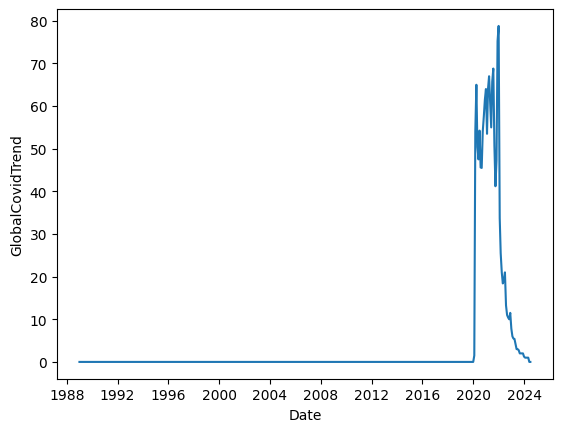

In [37]:
sns.lineplot(final_dict['Maldives'].reset_index(names='Date'), x='Date', y='GlobalCovidTrend')

In [38]:
final_dict['Thailand'][final_dict['Thailand']['VisitorArrivals'].isna()]

,VisitorArrivals,FXAgainstChina,CovidCases,CovidDeaths,FSI,GDPPerCap,GDP,Population,HotelsCount,RoomsCount,TravelPolicy,Temperature,Precipitation,GlobalCovidTrend,Latitude,Longitude,DistFromChina,Country
1989-01-01,NaN,6.784561,0.0,0.0,NaN,6522.000000,3.637478e+11,55772169.0,NaN,NaN,0.0,24.9,20.6,0.00,15.870032,100.992541,2237.67362,Thailand
1989-02-01,NaN,6.802541,0.0,0.0,NaN,6570.333333,3.669088e+11,55837671.0,NaN,NaN,0.0,25.6,6.7,0.00,15.870032,100.992541,2237.67362,Thailand
1989-03-01,NaN,6.830051,0.0,0.0,NaN,6618.666667,3.700698e+11,55903174.0,NaN,NaN,0.0,27.1,52.5,0.00,15.870032,100.992541,2237.67362,Thailand
1989-04-01,NaN,6.840328,0.0,0.0,NaN,6667.000000,3.732307e+11,55968676.0,NaN,NaN,0.0,29.8,66.0,0.00,15.870032,100.992541,2237.67362,Thailand
1989-05-01,NaN,6.901245,0.0,0.0,NaN,6715.333333,3.763917e+11,56034178.0,NaN,NaN,0.0,28.7,205.7,0.00,15.870032,100.992541,2237.67362,Thailand
1989-06-01,NaN,6.943375,0.0,0.0,NaN,6763.666667,3.795527e+11,56099680.0,NaN,NaN,0.0,27.8,183.4,0.00,15.870032,100.992541,2237.67362,Thailand
1989-07-01,NaN,6.920931,0.0,0.0,NaN,6812.000000,3.827136e+11,56165182.0,NaN,NaN,0.0,27.9,214.1,0.00,15.870032,100.992541,2237.67362,Thailand
1989-08-01,NaN,6.932705,0.0,0.0,NaN,6860.333333,3.858746e+11,56230685.0,NaN,NaN,0.0,27.6,240.2,0.00,15.870032,100.992541,2237.67362,Thailand
1989-09-01,NaN,6.971210,0.0,0.0,NaN,6908.666667,3.890356e+11,56296187.0,NaN,NaN,0.0,27.4,220.2,0.00,15.870032,100.992541,2237.67362,Thailand
1989-10-01,NaN,6.932811,0.0,0.0,NaN,6957.000000,3.921966e+11,56361689.0,NaN,NaN,0.0,26.5,207.8,0.00,15.870032,100.992541,2237.67362,Thailand


# Save Tables

In [39]:
save_dir = './data/processed'
os.makedirs(save_dir, exist_ok=True)
for k, v in final_dict.items():
    v.reset_index(names='Date').to_csv(os.path.join(save_dir, f'{k}.csv'), index=False)